In [845]:
from UNet import *
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import deepdish as dd

### load data

In [2]:
raw_image = dd.io.load('sample_origonal_images.h5')
vector_field = dd.io.load('vector_fields.h5')
keypoints_ground_truth = dd.io.load('clean_labeled_data.h5')

In [3]:
n_imgs = len(raw_image)
n_input_channel = 1
n_vf_channel = 4
size = raw_image[0].shape[0]
raw_image = raw_image.reshape(n_imgs, n_input_channel, size, size)

In [4]:
factor = 9

In [5]:
down_inputs = raw_image[:, :, ::factor,::factor] / factor
down_vf = vector_field[:, :, ::factor, ::factor] / factor

In [6]:
down_inputs_pad = np.zeros((n_imgs, n_input_channel, 96, 96))
down_vf_pad = np.zeros((n_imgs, n_vf_channel, 96, 96))

In [7]:
down_inputs_pad[:,:,:94, :94] = down_inputs
down_vf_pad[:,:,:94, :94] = down_vf

In [8]:
size = down_inputs.shape[-1]

### plot loss curve for one of CV models

In [9]:
loss_array = dd.io.load('./model/unet_mse_loss_cv_leave_one_out.h5')

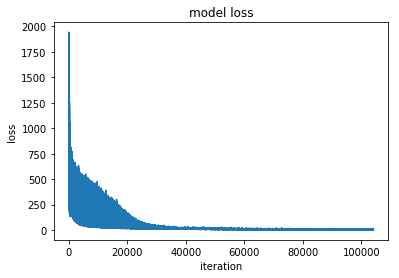

In [10]:
plt.plot(loss_array)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('model loss')
plt.show()

### lode one of CV pre-trained models and validation indeces

In [11]:
model = torch.load('./model/unet_gpu_cv_leave_one_out.pkl')
validation_indeces = np.load('./model/validation_indeces.npy')

There are 105 data. I use the first a hundard data to do 10 out of 100 cross validation and the rest five data can be used for test at last.

In [12]:
validation_indeces

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

shape of ten validation data

In [13]:
down_inputs_pad[validation_indeces[0]].shape

(10, 1, 96, 96)

In [14]:
n_vali_data = len(down_inputs_pad[validation_indeces[0]])

I use validation dataset to verify if the model do well or not

In [15]:
test_data = torch.from_numpy(down_inputs_pad[validation_indeces[0]]).float()
test_data = Variable(test_data).cuda()

In [16]:
prediction = model(test_data)

In [17]:
prediction_vf = prediction.data.cpu().numpy().reshape(n_vali_data, 4, 96, 96)

### result visualization e.g. for the 1st data 

In [18]:
vali_data_index = 1

In [19]:
prediction_vf.shape

(10, 4, 96, 96)

In [20]:
ground_truth = vector_field[vali_data_index]

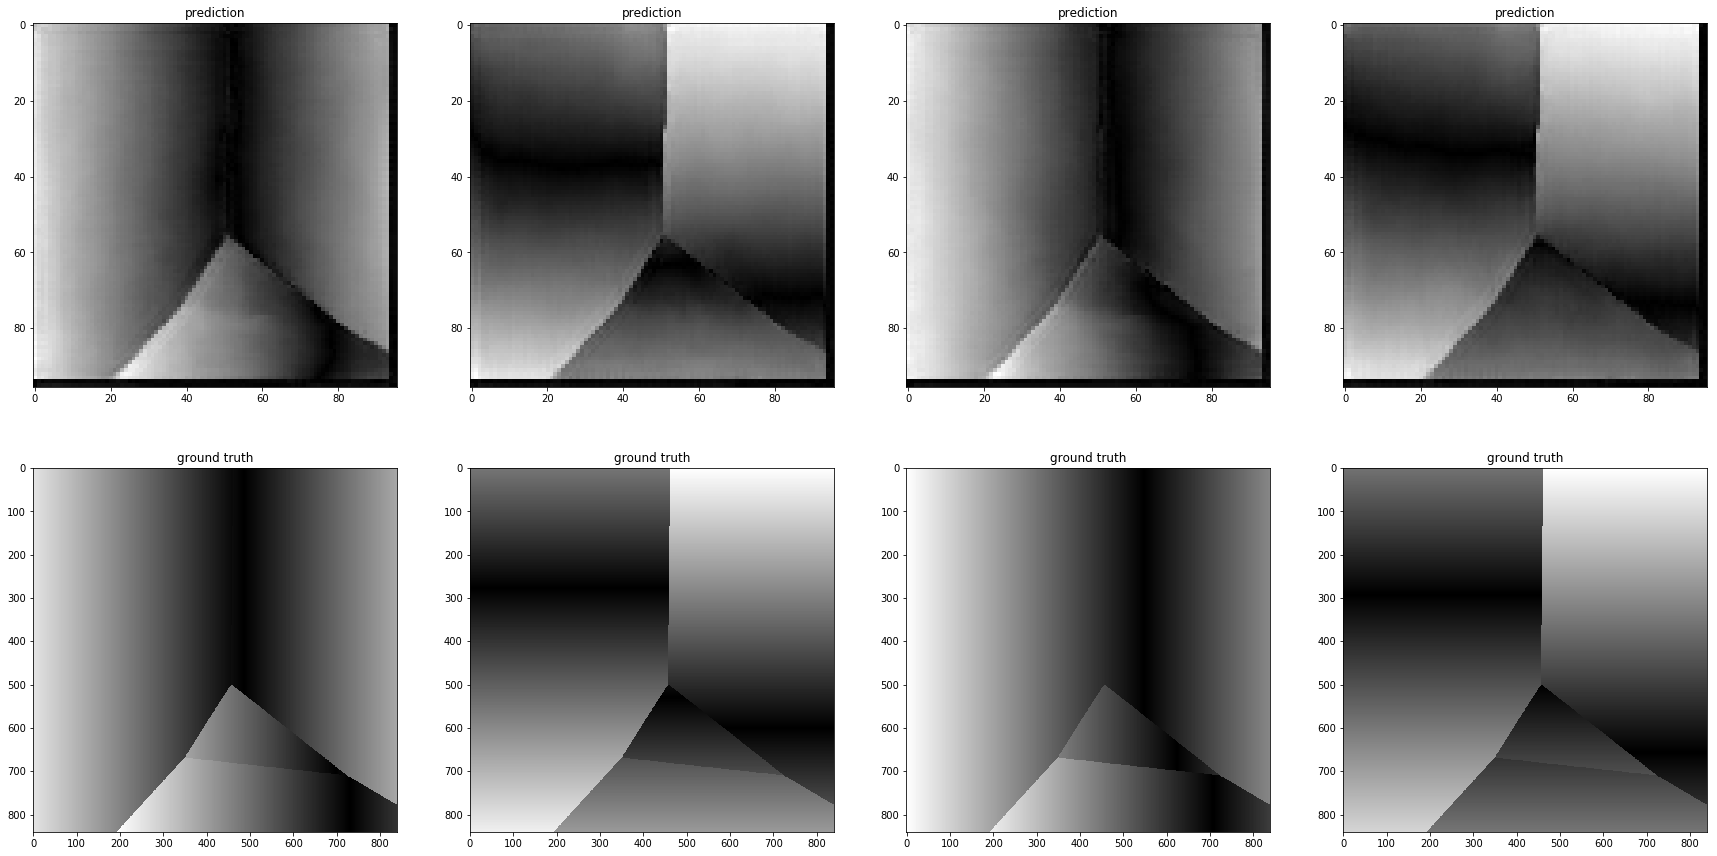

In [701]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
for i in range(8):
    plt.subplot(2, 4, i+1)
    if i <= 3:
        plt.imshow(np.abs(prediction_vf[vali_data_index][i%4]), cmap='gray')
        plt.title('prediction')
        
    else:
        plt.imshow(np.abs(ground_truth[i%4]), cmap='gray')
        plt.title('ground truth')
plt.show()

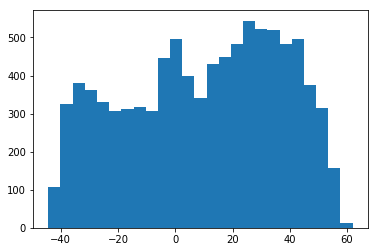

In [722]:
plt.hist(prediction_vf[vali_data_index][0].flatten(), bins='auto')  # arguments are passed to np.histogram
plt.show()

In [726]:
ground_truth[0].shape

(840, 840)

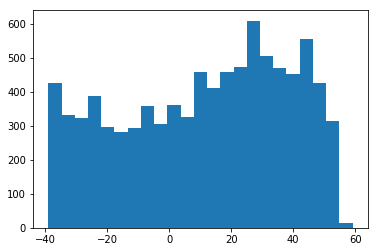

In [727]:
data = ground_truth[0][::factor,::factor] / factor
plt.hist(data.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.show()

### create abs distance matrices

In [22]:
abs_distance = np.zeros_like(prediction_vf)

### 4 channels meaning: (dxh, dyh, dxt, dyt)

In [23]:
abs_distance.shape

(10, 4, 96, 96)

### compute abs distance

In [24]:
def compute_abs_dist(abs_distance):
    pad_distance = np.arange(abs_distance.shape[2])
    n_repeat = abs_distance.shape[2]
    n_data = abs_distance.shape[0]
    
    for i in range(n_data):
        abs_distance[i][1] = abs_distance[i][3] = np.repeat(pad_distance.reshape(-1,1), n_repeat, axis=1)
        abs_distance[i][0] = abs_distance[i][2] = np.repeat(pad_distance.reshape(1,-1), n_repeat, axis=0)
    
    return abs_distance

In [25]:
abs_distance = compute_abs_dist(abs_distance)

### add abs distance to vector field in order to figure out the coordinate of key_points by prediction

In [488]:
abs_vf = prediction_vf + abs_distance

In [471]:
prediction_vf[0,0].shape

(96, 96)

### visualize prediction of key_points e.g. for the first validation data

In [472]:
np.set_printoptions(precision=3)

In [473]:
x_coordinate = abs_vf[vali_data_index][0]
y_coordinate = abs_vf[vali_data_index][1]

In [474]:
abs_vf.shape

(10, 4, 96, 96)

In [475]:
## padding with zero rows and columns
#down_sample_groundtrutch = np.zeros((n_vf_channel, 96, 96))
#down_sample_groundtrutch[:,:94,:94] = ground_truth[:,:94, :94]
#abs_vf = down_sample_groundtrutch + abs_distance[0]
#x_coordinate = abs_vf[0]
#y_coordinate = abs_vf[1]

In [476]:
np.where(x_coordinate == 0)

(array([], dtype=int64), array([], dtype=int64))

In [477]:
x_coordinate.shape

(96, 96)

In [478]:
y_coordinate.shape

(96, 96)

In [479]:
#x_coordinate = ground_truth[vali_data_index][0]
#y_coordinate = ground_truth[vali_data_index][1]

try to cut boundarys 

In [480]:
x_coordinate = x_coordinate[:94,:94]
y_coordinate = y_coordinate[:94,:94]

In [481]:
coordinates = np.zeros(shape=(x_coordinate.shape[0]*x_coordinate.shape[1], 2))

In [482]:
coordinates[:,0] = x_coordinate.flatten()
coordinates[:,1] = y_coordinate.flatten()

In [483]:
coordinates.dtype

dtype('float64')

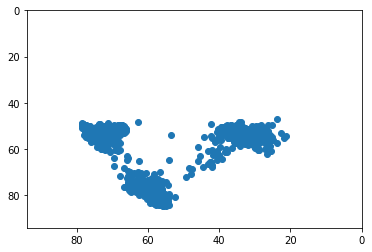

In [524]:
plt.scatter(y_coordinate.flatten(), x_coordinate.flatten())
plt.xlim(94, 0)
plt.ylim(94, 0)
plt.show()

### ground truth key points location

In [209]:
n_output_channel = 4
n_gt_imgs = 1

In [210]:
down_inputs_pad_gt = np.zeros((n_gt_imgs, n_output_channel, 96, 96))

In [211]:
one_gt = ground_truth.reshape(n_gt_imgs, n_output_channel, ground_truth.shape[1], ground_truth.shape[2])

In [214]:
down_inputs_pad_gt[:,:,:94, :94] = one_gt[:,:,::factor,::factor] / factor

In [218]:
abs_distance_gt = np.zeros_like(down_inputs_pad_gt)
abs_distance_gt = compute_abs_dist(abs_distance_gt)

In [219]:
abs_vf_gt = down_inputs_pad_gt + abs_distance_gt

In [300]:
x_coordinate_gt = abs_vf_gt[0][0]
y_coordinate_gt = abs_vf_gt[0][1]

In [301]:
x_coordinate_gt = x_coordinate_gt[:94,:94]
y_coordinate_gt = y_coordinate_gt[:94,:94]

In [303]:
coordinates_gt = np.zeros(shape=(x_coordinate_gt.shape[0]*x_coordinate_gt.shape[1], 2))

In [304]:
coordinates_gt.shape

(8836, 2)

In [305]:
coordinates_gt[:,0] = x_coordinate_gt.flatten()
coordinates_gt[:,1] = y_coordinate_gt.flatten()

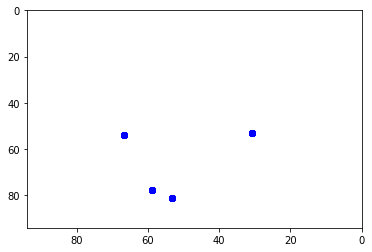

In [522]:
plt.scatter(y_coordinate_gt.flatten(), x_coordinate_gt.flatten(), c='blue', alpha=1)
plt.xlim(94, 0)
plt.ylim(94, 0)
plt.show()

### use k-means to figure out 8 centroids, namely 8 keypoints

In [805]:
n_keypoints = 4

In [806]:
kmeans = KMeans(n_clusters=n_keypoints, random_state=0).fit(coordinates)

In [807]:
predict_keypoints = kmeans.cluster_centers_

In [808]:
predict_keypoints

array([[ 52.243,  71.947],
       [ 52.438,  36.327],
       [ 79.133,  58.496],
       [ 53.517,  31.227]])

In [809]:
keypoints_ground_truth.shape

(105, 840, 840)

In [810]:
background = np.ones(shape=(96, 96))

In [811]:
down_inputs_pad.shape

(105, 1, 96, 96)

In [812]:
example_img = down_inputs_pad[1].reshape(96,96)

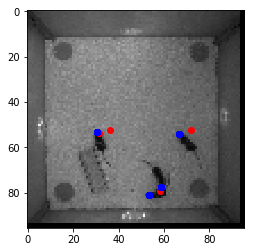

In [813]:
plt.imshow(example_img, cmap='gray')
#plt.imshow(background, cmap='gray')
colors = np.random.rand(n_keypoints)
plt.scatter(predict_keypoints[:,1], predict_keypoints[:,0], c='red', alpha=1)
plt.scatter(y_coordinate_gt.flatten(), x_coordinate_gt.flatten(), c='blue', alpha=1)
plt.show()

### remove outliers for the prediction

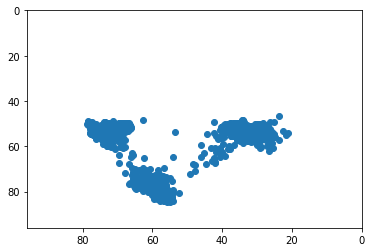

In [780]:
plt.scatter(y_coordinate.flatten(), x_coordinate.flatten())
plt.xlim(96, 0)
plt.ylim(96, 0)
plt.show()

In [489]:
first_pred_vf = prediction_vf[0]

In [490]:
first_pred_abs_dist = abs_distance[0]

In [463]:
first_pred_abs_dist.shape

(4, 96, 96)

In [464]:
first_pred_vf.shape

(4, 96, 96)

In [883]:
def remove_outliers(vf, pos_dist, threshold):
    """
    this function is for only one data. If you want to remove outliers for more than one data, 
    then you have to change the code
    return: coordinate list which is within threshold
    """
    n_channels = 4
    n_body_parts = 2 # head and tail
    head_coords_list_threshold = []
    tail_coords_list_threshold = []
    
    # step 1: flatten vector fields and figure out the x and y row coordinates for head and tail seperately
    # coordinates_flatten contains (h_rows_x, h_rows_y, t_rows_x, t_rows_y)
    # flatten the postive distance tensor as well. it contains its cooresponding coordinates
    coordinates_flatten = vf.reshape(n_channels, -1)
    pos_dist_flatten = pos_dist.reshape(n_channels, -1)
    
    # step 2: keep abs(coordinates_flatten) and its corresponding pos_dist_flatten which is within the threshold
    # note: remove x and its coorsponding y at the same time
    k = 0
    #for i in range(n_body_parts):
    total_dist_h = np.abs(coordinates_flatten[0]) + np.abs(coordinates_flatten[1])
    total_dist_t = np.abs(coordinates_flatten[2]) + np.abs(coordinates_flatten[3])
    #logical_discri = np.logical_or(np.abs(coordinates_flatten[k]) <= threshold, np.abs(coordinates_flatten[k+1] <= threshold))
    ##indeces = np.where(total_dist_h <= threshold)
    #indeces = np.where(logical_disc)
    indeces = np.logical_and(total_dist_h <= threshold, total_dist_t <= threshold)
    
        # x coordinate
    x_coor = coordinates_flatten[0][indeces] + pos_dist_flatten[0][indeces]
    head_coords_list_threshold.append(x_coor)
    # y coordinate
    y_coor = coordinates_flatten[1][indeces] + pos_dist_flatten[1][indeces]
    head_coords_list_threshold.append(y_coor)
    # x coordinate
    x_coor = coordinates_flatten[2][indeces] + pos_dist_flatten[2][indeces]
    tail_coords_list_threshold.append(x_coor)
    # y coordinate
    y_coor = coordinates_flatten[3][indeces] + pos_dist_flatten[3][indeces]
    tail_coords_list_threshold.append(y_coor)
    #k += 2
    
    # step 3: add them up in order to get coordinates to plot scatter
    return head_coords_list_threshold, tail_coords_list_threshold

In [884]:
one_vf = prediction_vf[1][:, :94, :94]

In [885]:
one_vf.shape

(4, 94, 94)

In [886]:
one_pos_dist = np.zeros((1, 4, 94, 94))
one_pos_dist = compute_abs_dist(one_pos_dist)
one_pos_dist = one_pos_dist.reshape(4, 94, 94)

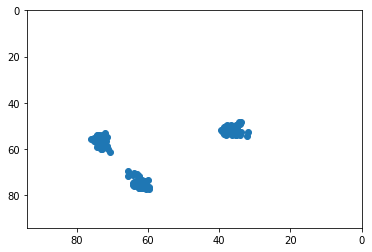

In [916]:
threshold = 20
h_coor_list_thre, t_coor_list_thre = remove_outliers(one_vf, one_pos_dist, threshold)
y_coordinate_thre = h_coor_list_thre[0]
x_coordinate_thre = h_coor_list_thre[1]
plt.scatter(x_coordinate_thre.flatten(), y_coordinate_thre.flatten())
plt.xlim(94, 0)
plt.ylim(94, 0)
plt.show()

In [836]:
coordinates_one_remove_outlier = np.zeros(shape=(len(x_coordinate_thre), 2))

In [837]:
coordinates_one_remove_outlier[:,0] = x_coordinate_thre
coordinates_one_remove_outlier[:,1] = y_coordinate_thre

In [838]:
kmeans = KMeans(n_clusters=n_keypoints, random_state=0).fit(coordinates_one_remove_outlier)

In [839]:
predict_keypoints_remove_outlier = kmeans.cluster_centers_

In [840]:
predict_keypoints_remove_outlier

array([[ 71.947,  52.243],
       [ 36.327,  52.438],
       [ 58.496,  79.133],
       [ 31.227,  53.517]])

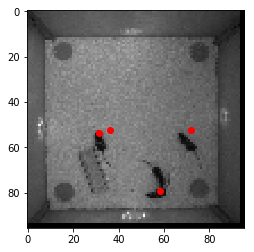

In [841]:
plt.imshow(example_img, cmap='gray')
#plt.imshow(background, cmap='gray')
colors = np.random.rand(n_keypoints)
plt.scatter(predict_keypoints_remove_outlier[:,0], predict_keypoints_remove_outlier[:,1], c='red', alpha=1)
#plt.scatter(y_coordinate_gt.flatten(), x_coordinate_gt.flatten(), c='blue', alpha=1)
plt.show()

### clustering for 4-d tensor namely (x_h,y_h,x_t,y_t)

test it utilize the previouse head and tail coordinates

In [890]:
#n_samples = 

In [891]:
n_dimensions = 4

four_d_tensor = (x_h, y_h, x_t, y_t)

In [892]:
four_d_tensor = np.zeros(shape=(h_coor_list_thre[0].shape[0], n_dimensions))

In [893]:
h_coor_list_thre[0].shape[0]

290

In [894]:
t_coor_list_thre[0].shape

(290,)

In [895]:
four_d_tensor[:,0] = h_coor_list_thre[0]
four_d_tensor[:,1] = h_coor_list_thre[1]
four_d_tensor[:,2] = t_coor_list_thre[0]
four_d_tensor[:,3] = t_coor_list_thre[1]

### plot tail to head in order to visualize vector

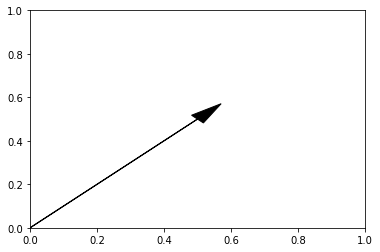

In [900]:
ax = plt.axes()
ax.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.show()

In [951]:
for i in range(len(four_d_tensor)):
    x = (four_d_tensor[i,1], four_d_tensor[i,3])
    y = (four_d_tensor[i,0], four_d_tensor[i,2]) 
    plt.xlim(0, 94)
    plt.ylim(94, 0)
    plt.plot(x, y)

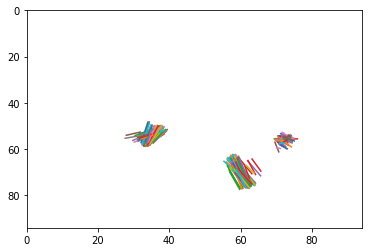

In [952]:
plt.show()

In [896]:
four_d_kmeans = KMeans(n_clusters=n_keypoints, random_state=0).fit(four_d_tensor)

In [897]:
four_d_centers = four_d_kmeans.cluster_centers_

In [898]:
four_d_centers

array([[ 51.611,  36.735,  57.417,  33.406],
       [ 76.052,  61.434,  67.611,  58.07 ],
       [ 56.085,  73.476,  55.363,  71.689],
       [ 74.541,  62.985,  64.165,  58.151]])

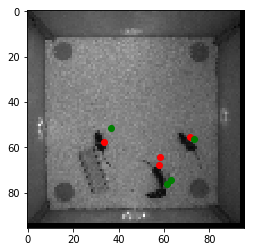

In [915]:
plt.imshow(example_img, cmap='gray')
#plt.imshow(background, cmap='gray')
colors = np.random.rand(n_keypoints)
plt.scatter(four_d_centers[:,3], four_d_centers[:,2], c='red', alpha=1) # tail prediction
plt.scatter(four_d_centers[:,1], four_d_centers[:,0], c='green', alpha=1) # head prediction
#plt.scatter(y_coordinate_gt.flatten(), x_coordinate_gt.flatten(), c='blue', alpha=1)
plt.show()

In [910]:
four_d_centers[:,3]

array([ 33.406,  58.07 ,  71.689,  58.151])

In [911]:
four_d_centers[:2]

array([[ 51.611,  36.735,  57.417,  33.406],
       [ 76.052,  61.434,  67.611,  58.07 ]])